## Data Analysis For Supercell



- Infra stuff

In [407]:
import pandas as pd
import numpy as np
import os 
companies = ['zynga','supercell','king']
mainBranches = pd.read_csv("../../datasets/marketingV/main_branches.csv",sep=';')

In [408]:
companies = ['Zynga','Supercell','King']
mainBranches = pd.read_csv("../../datasets/marketingV/main_branches.csv",sep=';')
branches = mainBranches[mainBranches.company_name.isin(companies)]
#Collect all the subject Ids related to our companies
subjects = pd.read_csv("../../datasets/marketingV/subjects_tree_data.csv",sep=';')
subjects.head()
def findValues(X):
    v = np.intersect1d(X[4].split(','),branches['branch_id'].values)
    if len(v) > 0:
        v = int(v[0])
        company = branches[branches.branch_id == v]['company_name'].values[0]
        prop = branches[branches.branch_id == v]['property'].values[0]
        return pd.Series({'subject_id': X[3],'branch_id':v,'subject':X[0],'property': prop,'company':company})
    else:
        return pd.Series()
subjects = subjects.apply(findValues,axis=1).dropna()
subjects.head()

,branch_id,company,property,subject,subject_id
10,1069691.0,Supercell,Boom Beach,Boom Beach,5073984.0
14,1013836.0,Zynga,Words With Friends,Words With Friends Pro,5338124.0
18,1013836.0,Zynga,Words With Friends,Words With Friends HD,5277124.0
19,1040093.0,Supercell,Clash Royale,Clash Royale,5450856.0
20,1069691.0,Supercell,Boom Beach,Boom Beach,5063087.0


### First Phase

- a) What is the average monthly user growth rates of Supercell, King and Zynga?
- b) What is the net reach of Supercell, King and Zynga in the sample for each of the 3 months?
- c) What is the total time spent per month per user for Supercell, King and Zynga for July?
- d) Which of Supercell, King and Zynga had the largest average session duration in June?
    - All of these require session data
- e) What is the gender distribution of Supercell vs. King users?
     - This can be looked up from gender data


In [409]:
sessiondataDump = pd.read_csv("../../datasets/marketingV/sessions_data.csv",sep=';')
sessionData = sessiondataDump[sessiondataDump.subject_id.isin(subjects.subject_id)]
del sessiondataDump
sessionData.head()
sessionData.head()
sessionData['start_timestamp'] = pd.to_datetime(sessionData['start_timestamp'])
sessionData['end_timestamp'] = pd.to_datetime(sessionData['end_timestamp'])
sessionData['month'] = sessionData['start_timestamp'].dt.month
sessionData = sessionData.merge(subjects[['subject_id','company']],how='left',left_on='subject_id',right_on='subject_id')
sessionData.head()

,subject_id,start_timestamp,end_timestamp,interaction_type,user_id,device_id,os,month,company
0,5144205,2016-05-06 13:33:38,2016-05-06 13:51:48,app,4530,10124,ios,5,Zynga
1,5144205,2016-07-01 18:12:55,2016-07-01 18:23:28,app,4530,10124,ios,7,Zynga
2,5144205,2016-06-05 23:53:40,2016-06-06 00:18:49,app,4530,10124,ios,6,Zynga
3,5144205,2016-07-01 11:45:36,2016-07-01 11:56:09,app,4530,10124,ios,7,Zynga
4,5144205,2016-06-02 14:57:03,2016-06-02 15:09:05,app,4530,10124,ios,6,Zynga


a) What is the average monthly user growth rates of Supercell, King and Zynga?

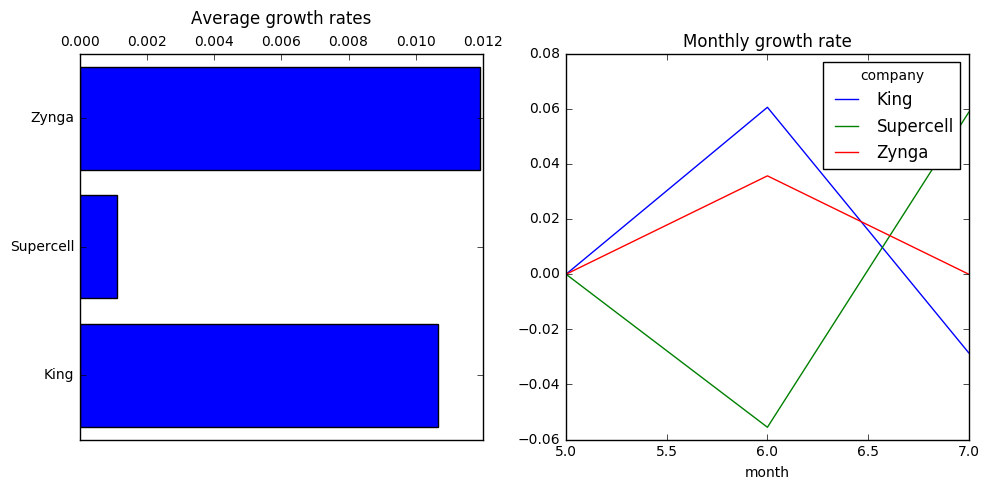

In [410]:
from matplotlib import pyplot as plt
%matplotlib inline
## Average growth rate
monthlyGroup= sessionData.groupby(['company','month'])['user_id'].nunique().reset_index()
a = monthlyGroup.pivot(index='month',columns='company',values='user_id')
gr = a.pct_change().fillna(0)
## PLotting
ind = np.arange(3)+0.5
fig,ax = plt.subplots(figsize=(10,5),nrows = 1,ncols=2)
ax[0].barh(ind,gr.mean(),align='center')
ax[0].set_yticks(ind, minor=False)
ax[0].set_yticklabels(gr.columns.values, minor=False)
ax[0].xaxis.tick_top()
t = ax[0].set_title("Average growth rates")
t.set_position([0.5,1.06])
gr.plot(ax=ax[1],title="Monthly growth rate")
plt.tight_layout()

b) What is the net reach of Supercell, King and Zynga in the sample for each of the 3 months?
    - net reach means total number of unique users engaged each month

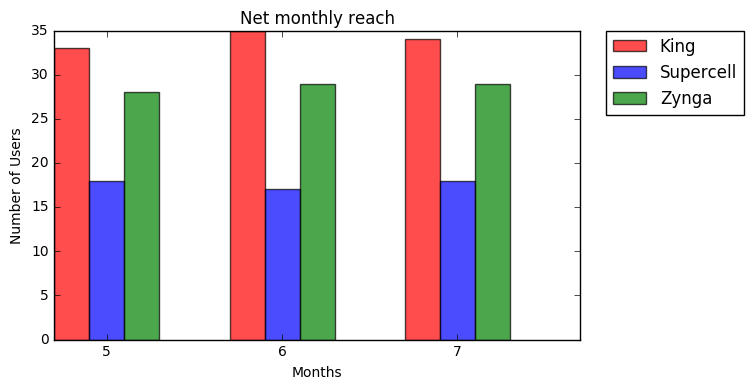

In [411]:
def plotBarsFromPivot(data,title,xlabel,ylabel):
    c = {0:'r',1:'b',2:'g'}
    for i,m in enumerate(data.columns.values):
        plt.bar(np.arange(data.shape[0])+0.2*i,data[m],width=0.2,color=c[i],alpha=0.7,label=m)
    plt.xticks(np.arange(data.shape[0])+0.2*(data.shape[0]/2.0),data.index.values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


plotBarsFromPivot(a,"Net monthly reach","Months","Number of Users")

c) What is the total time spent per month per user for Supercell, King and Zynga for July?

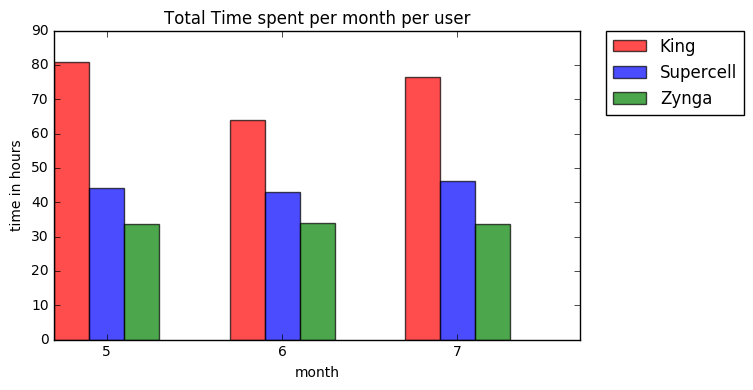

In [412]:
#Get session duration
sessionData['session'] = sessionData['end_timestamp'] - sessionData['start_timestamp']
#Group by monthly and count number of unique users as well as total session duration
g = sessionData.groupby(['company','month']).agg({'user_id': lambda x: x.nunique(),
                                                  'session': lambda x: x.sum()}).reset_index()
g['sessionPerUser'] = (g['session']/g['user_id']).astype('timedelta64[s]')/3600.0
spu = g.pivot(index='month',columns='company',values='sessionPerUser')
plotBarsFromPivot(spu,"Total Time spent per month per user","month","time in hours")

Which of Supercell, King and Zynga had the largest average session duration in June?
    

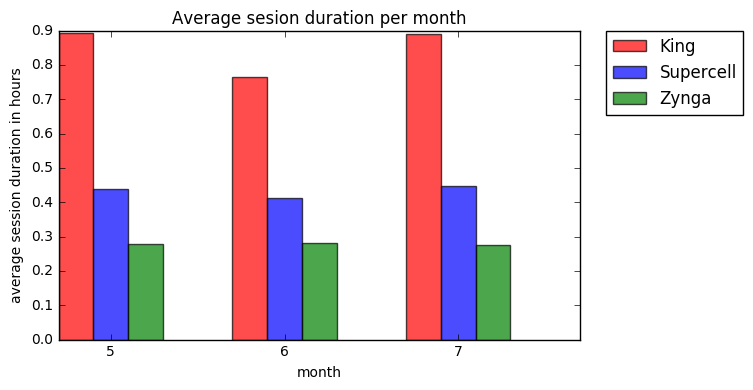

In [413]:
g = sessionData.groupby(['company','month']).agg({'session': lambda x: x.mean()}).reset_index()
g['session'] = g['session'].astype('timedelta64[s]')/3600.0
ast = g.pivot(index='month',columns='company',values='session')
plotBarsFromPivot(ast,"Average sesion duration per month","month","average session duration in hours")

Thus the answer seems to be  King

e) What is the gender distribution of Supercell vs. King users?
    - Load demographics and merge it with the session data 

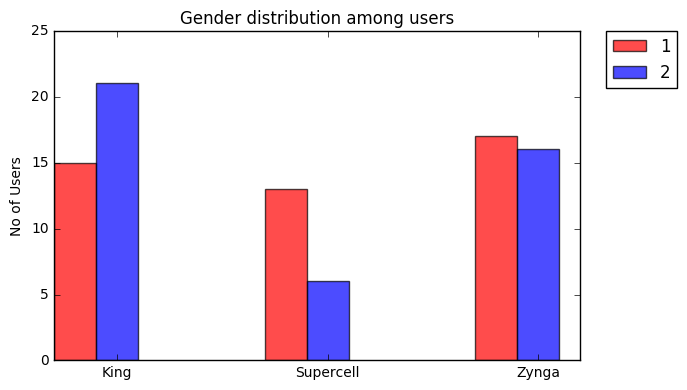

In [414]:
users = pd.read_csv("../../datasets/marketingV/demographics_data.csv",sep=';')
users.head()
sessionDemoG = sessionData.merge(users[['user_id','gender','age','income_level']],how='left',left_on='user_id',right_on='user_id')
del users
gdist = sessionDemoG.groupby(['company','gender']).agg({'user_id': lambda x: x.nunique()}).reset_index()
gdp = gdist.pivot(index='company',columns='gender',values='user_id')
plotBarsFromPivot(gdp,"Gender distribution among users","","No of Users")

Thus it can be observed that gender distribution is reversed in between King and supercell, i.e. More males play King while more females play supercell or vice versa

#### Analysis part 2
Clash of Clans vs. Candy Crush Saga
In phase 2 of the analysis we are interested to study Clash of Clans and Candy Crush Saga
gamers in particular by answering the following questions:

a) What’s the reach of Clash of Clans among Candy Crush Saga users?

b) What’s the reach of Candy Crush Saga among users aged 35 or above? How does this
compare to Clash of Clans?

c) How many users play Candy Crush Saga on Tablets?

d) What’s the deduplicated net reach of Clash of Clans and Candy Crush Saga
combined?

- This requires specific analysis for candy crush saga and clash of the clans

In [415]:
candyCrush = subjects[subjects.subject == 'Candy Crush Saga']['subject_id'].values
clashClans = subjects[subjects.subject == 'Clash of Clans']['subject_id'].values

a) What’s the reach of Clash of Clans among Candy Crush Saga users?
    - It can be represented by percentage of candy crush players who also play Clash of clans 

In [416]:
candyCrushUsers = set(sessionDemoG[sessionDemoG.subject_id.isin(candyCrush)]['user_id'].values)
clashClansUsers = set(sessionDemoG[sessionDemoG.subject_id.isin(clashClans)]['user_id'].values)
commonPlayers = candyCrushUsers.intersection(clashClansUsers)
print "Clash of clans reaches ",100.0*len(commonPlayers)/len(candyCrushUsers),"% of candy crush users"

Clash of clans reaches  7.40740740741 % of candy crush users


b) What’s the reach of Candy Crush Saga among users aged 35 or above? How does this compare to Clash of Clans?
    - Basically percentage of candy crush/clash of clans users in above 35 users

In [261]:
above35 = set(sessionDemoG[sessionDemoG.age >= 35]['user_id'].values)
CandyCrushAbove35 = 100*len(candyCrushUsers.intersection(above35))/len(above35)
ClashClanAbove35 = 100*len(clashClansUsers.intersection(above35))/len(above35)
print "Candy crush saga reaches",CandyCrushAbove35,"% of users older than 35"
print "While, Clash of clan reaches",ClashClanAbove35,"% of users older than 35"

Candy crush saga reaches 36 % of users older than 35
While, Clash of clan reaches 17 % of users older than 35


c) How many users play Candy Crush Saga on Tablets?
    - Candy crush players that play on tablet; basically join with device data and find how many are on tablet

In [417]:
devices =  pd.read_csv("../../datasets/marketingV/devices_data.csv",sep=';')
sessionDemoG = sessionDemoG.merge(devices[['device_id','device_type']], how='left', left_on="device_id",right_on="device_id")
del devices

In [418]:
tbltCndcrshPlayers = sessionDemoG[(sessionDemoG.subject_id.isin(candyCrush))  & (sessionDemoG.device_type == 'Tablet')]['user_id'].unique()
print len(tbltCndcrshPlayers), "users play candy crush on tablet"
print "which is",100*len(tbltCndcrshPlayers)/len(candyCrushUsers),"% of total candy crush players!"

7 users play candy crush on tablet
which is 25 % of total candy crush players!


d) What’s the deduplicated net reach of Clash of Clans and Candy Crush Saga combined?
    - What percentage of total users play at least one of these games. Here, total users means all the users we have session data available for.
    

In [419]:
gamers = candyCrushUsers.union(clashClansUsers)
datadump = pd.read_csv("../../datasets/marketingV/sessions_data.csv",sep=';')
totalUsers = datadump['user_id'].unique().copy()
print "Thus, deduplicated net reach of Clash of Clans and Candy Crush combined is",100*len(gamers)/len(totalUsers),"% of total users"

Thus, deduplicated net reach of Clash of Clans and Candy Crush combined is 38 % of total users


#### Analysis Phase 3
In phase 3 we will analyze the channels to reach gamers who are not yet Supercell users and who Supercell would like to target with ad campaigns to convert them. To do so we need to answer the following questions:

a) What’s the reach of each of YouTube, Facebook, Amazon and Walmart among King and Zynga gamers who are not Supercell gamers?

b) What is Facebook’s average number of sessions per active user per month among Clash of Clan players? And what is it among Candy Crush Saga users?
    - We need supercell Users as well and also we would need full session data instead of shortened version

In [420]:
channels = ['Facebook','Amazon','Walmart','Google']
companies = ['Zynga','Supercell','King']
allCompanies = channels + companies
branches = mainBranches[mainBranches.company_name.isin(allCompanies)]
#Collect all the subject Ids related to all companies
subjects = pd.read_csv("../../datasets/marketingV/subjects_tree_data.csv",sep=';')
subjects = subjects.apply(findValues,axis=1).dropna()

a) What’s the reach of each of YouTube, Facebook, Amazon and Walmart among King and Zynga gamers who are not Supercell gamers?
    - Find out percentage of FB etc users among non supercell king, zynga users
    

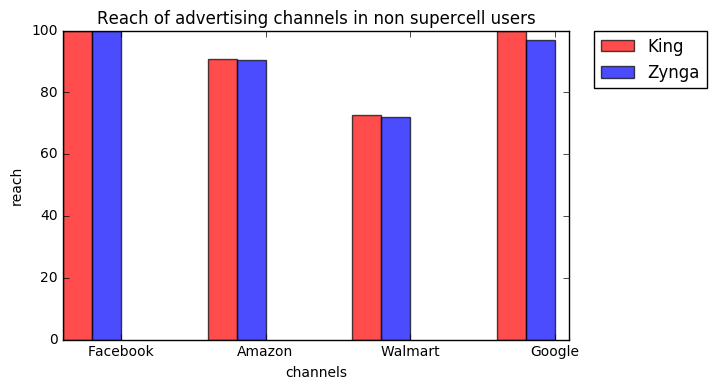

In [421]:
supercellUsers = set(datadump[datadump.subject_id.isin(subjects[subjects.company == 'Supercell']['subject_id'])]['user_id'])
kingUsers = set(datadump[datadump.subject_id.isin(subjects[subjects.company == 'King']['subject_id'])]['user_id'])
zyngaUsers = set(datadump[datadump.subject_id.isin(subjects[subjects.company == 'Zynga']['subject_id'])]['user_id'])
nonSKingUsers = kingUsers.difference(supercellUsers)
nonSZyngaUsers = zyngaUsers.difference(supercellUsers)
pivot = {}
pivot['King']=[]
pivot['Zynga']=[]
for channel in channels:
    channelUsers = set(datadump[datadump.subject_id.isin(subjects[subjects.company == channel]['subject_id'])]['user_id'])
    reachedKing = channelUsers.intersection(nonSKingUsers)
    reachedZynga = channelUsers.intersection(nonSZyngaUsers)
    pivot['King'].append(100.0*len(reachedKing)/len(nonSKingUsers))
    pivot['Zynga'].append(100.0*len(reachedZynga)/len(nonSZyngaUsers))
pivot = pd.DataFrame(pivot,index=channels)
plotBarsFromPivot(pivot,"Reach of advertising channels in non supercell users","channels","reach")
#pivot['channels'] = channels

b) What is Facebook’s average number of sessions per active user per month among Clash of Clan players? And what is it among Candy Crush Saga users?

    - Find FB session, group by months and game
    - Its easier if session data have month appended already 
    
    

In [422]:
facebookSessions = datadump[datadump.subject_id.isin(subjects[subjects.company=='Facebook']['subject_id'])].copy()
facebookSessions['start_timestamp'] = pd.to_datetime(facebookSessions['start_timestamp'])
facebookSessions['month'] = facebookSessions['start_timestamp'].dt.month
candyCrushUsers = set(datadump[datadump.subject_id.isin(candyCrush)]['user_id'])
clashClansUsers = set(datadump[datadump.subject_id.isin(clashClans)]['user_id'])
def getPlayerCounts(X):
    return pd.Series({'CandyCrush': X[X.user_id.isin(candyCrushUsers)].shape[0]/float(len(candyCrushUsers)),
                     'ClashOfClans': X[X.user_id.isin(clashClansUsers)].shape[0]/float(len(clashClansUsers))})
monthlySessions = facebookSessions.groupby(['month']).apply(getPlayerCounts)

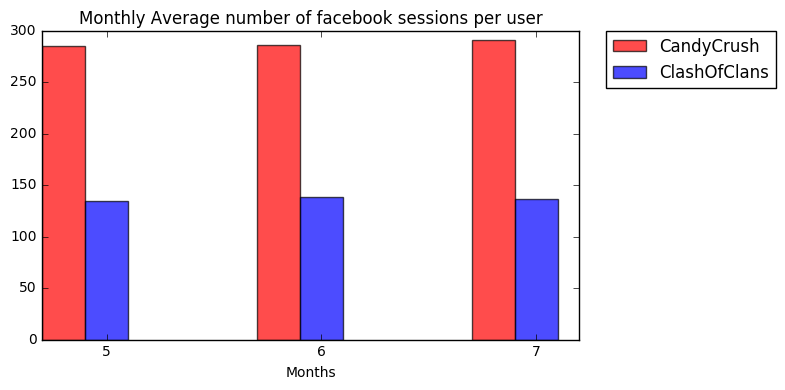

In [423]:
plotBarsFromPivot(monthlySessions,"Monthly Average number of facebook sessions per user","Months","")



### This ends data analysis for supercell.








        - Sudhanshu